In [7]:
import os
from typing import Optional

import pandas as pd
import torch
import torchvision
import wget

from matplotlib import pyplot as plt
from torchvision import transforms
import albumentations 
import cv2
import numpy as np

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Using cache found in C:\Users\rraccah/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\rraccah\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rraccah\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
CLASSES = ['cat-Abyssinian', 'cat-Bengal', 'cat-Birman', 'cat-Bombay', 'cat-British_Shorthair', 'cat-Egyptian_Mau', 'cat-Maine_Coon', 'cat-Persian', 'cat-Ragdoll', 'cat-Russian_Blue', 'cat-Siamese', 'cat-Sphynx', 'dog-american_bulldog', 'dog-american_pit_bull_terrier', 'dog-basset_hound', 'dog-beagle', 'dog-boxer', 'dog-chihuahua', 'dog-english_cocker_spaniel', 'dog-english_setter', 'dog-german_shorthaired', 'dog-great_pyrenees', 'dog-havanese', 'dog-japanese_chin', 'dog-keeshond', 'dog-leonberger', 'dog-miniature_pinscher', 'dog-newfoundland', 'dog-pomeranian', 'dog-pug', 'dog-saint_bernard', 'dog-samoyed', 'dog-scottish_terrier', 'dog-shiba_inu', 'dog-staffordshire_bull_terrier', 'dog-wheaten_terrier', 'dog-yorkshire_terrier']
CLASS_DIC = {class_name: index for index, class_name in enumerate(CLASSES)}
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
BATCH_SIZE = 32

In [9]:
def transform_image(path, bboxes, category_ids):
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'x_max', 'y_max', "class_id"]}
    """
    # create resize transform pipeline
    print(f'{path=}')
    image = cv2.imread(path)
   
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    #plt.imshow(image)
    transform = albumentations.Compose(
        [albumentations.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='pascal_voc',label_fields=['category_ids']))

    transformed = transform(image=image, bboxes=bboxes,category_ids=category_ids)
    return transformed

path='data_pets\\test\\saint_bernard_12_jpg.rf.06fdb9dba5da1544ef5cab27034275f5.jpg'


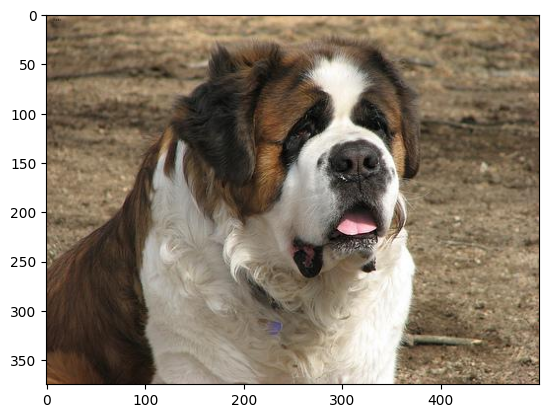

In [10]:
# dataset and augmentations
class CustomDataset(torch.utils.data.Dataset):
    """
    Make a Dataset out of a local copy of in the TensorFlow Object Detection format.
    """

    def __init__(self, data_dir: str,transform: albumentations = None):
        self.data_dir = data_dir
        self.transform = transform
        self.annotations = pd.read_csv(os.path.join(data_dir, "_annotations.csv"))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx: int):
        # Get the image file path
        img_path = os.path.join(self.data_dir, self.annotations.iloc[idx, 0])

        # Get the label
        label = [CLASS_DIC[self.annotations.iloc[idx, 3]]]

        # Get BBox
        x_min, y_min, x_max, y_max = self.annotations.iloc[idx, 4:8]
        bbox = [[x_min, y_min, x_max, y_max]]

        transformed_dict = transform_image(img_path, bbox, label)

        # contains the image as array
        image = transformed_dict["image"]
        image = torch.from_numpy(image).to(dtype=torch.float32) / 255.
        image = image.permute(2, 0, 1)
        # contains the resized bounding boxes
        new_bbox = transformed_dict["bboxes"]
        #   print(new_bbox)
        bbox = np.array(list(map(list, new_bbox))).astype(int)[0]

        bbox = torch.from_numpy(bbox).to(dtype=torch.float32)

        return image, label[0], bbox

# Define Datasets and DataLoaders
TEST_DATASET = CustomDataset(data_dir="data_pets\\test")
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE, shuffle=False)

image, label, _ = TEST_DATASET[5]

In [11]:
input_batch = image.unsqueeze(0)  # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Forward pass of the input through the model
with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000 (amount of labels in ImageNet), with confidence scores over ImageNet's 1000 classes
print(output[0])

# The output has unnormalized scores. To get probabilities, we apply softmax.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([-6.9189e-01, -2.0237e+00,  3.5483e+00,  1.6009e+00,  2.7236e+00,
        -8.6745e-01,  2.3691e+00,  1.9083e+00,  1.7156e+00, -6.6278e-01,
        -3.1306e+00, -2.3694e+00, -4.0533e+00, -5.3833e-01, -4.4236e+00,
        -2.5082e+00, -1.4125e+00, -3.2214e+00, -1.2880e+00, -2.7418e+00,
        -1.5278e+00, -1.4043e+00, -1.9396e+00,  1.2030e+00, -1.2074e+00,
        -2.5076e+00, -4.2764e+00, -5.8294e+00, -4.8915e+00, -2.9808e+00,
        -3.1985e+00, -2.5698e+00, -4.8960e+00,  3.9866e+00,  3.2761e+00,
        -1.2022e+00, -3.4875e-02, -3.4838e-01, -2.2935e+00,  1.1337e+00,
        -1.4472e-01, -4.1598e+00, -2.6896e+00, -2.8535e+00, -3.4257e+00,
        -1.5696e+00, -4.0642e-01, -1.1006e+00,  1.7696e+00, -2.2082e-01,
        -2.4581e-01, -2.2022e+00, -2.0572e+00, -1.6108e+00,  5.9707e-02,
        -1.8830e+00, -1.1062e+00, -2.6992e+00, -9.1909e-01, -3.8424e+00,
         6.1899e-01,  1.8783e-01,  8.6853e-01,  2.0605e-01, -2.0216e+00,
        -1.0300e+00, -2.6035e+00,  2.8895e-01, -3.5

Model predictions:

Saint Bernard 0.9575095176696777
boxer 0.021923985332250595
Greater Swiss Mountain dog 0.009764243848621845


Original label dog-saint_bernard


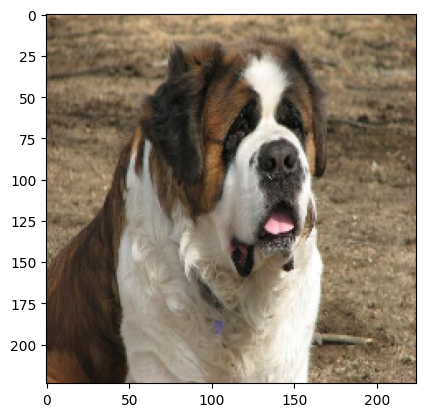

In [12]:
# Download ImageNet labels
if not os.path.isfile("imagenet_classes.txt"):
    wget.download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt")

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top categories per image
top3_prob, top3_catid = torch.topk(probabilities, 3)
print("Model predictions:\n")
for i in range(top3_prob.size(0)):
    print(categories[top3_catid[i]], top3_prob[i].item())

print("\n")
print(f"Original label {CLASSES[label]}")
# Plot image
plt.imshow(image.permute(1, 2, 0))